In [1]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scanorama
import os
style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

In [2]:
def load_layer(patient, sample, metadata):
    """
    Return Layer object of Patient, Sample
    """
    layer = "../data/P" + str(patient) + "/layer" + str(sample) + ".tsv"
    coor_path = "../data/P" + str(patient) + "/layer" + str(sample) + "_coordinates.tsv"
    adata = anndata.read_csv(layer, delimiter="\t")

    # Data pre-processing
    coor = pd.read_csv(coor_path, sep="\t").iloc[:,:2]
    coor_index = []
    for pair in coor.values:
        coor_index.append('x'.join(str(e) for e in pair))
    coor.index = coor_index
    # The metadata, coordinates, and gene expression might have missing cells between them
    idx = paste.intersect(coor_index, adata.obs.index)
    
    df = metadata[metadata['patient'] == patient]
    df = df[df['sample'] == sample]
    
    meta_idx = []
    for i in df.index:
        meta_idx.append(i.split('_')[1])
    idx = paste.intersect(idx, meta_idx)
    
    adata = adata[idx, :]
    adata.obsm['spatial'] = np.array(coor.loc[idx, :])
    metadata_idx = ['P' + str(patient) + '_' + i + '_' + str(sample) for i in idx]
    adata.obs['original_clusters'] = [str(x) for x in list(metadata.loc[metadata_idx, 'SCT_snn_res.0.8'])]
    return adata

In [3]:
metadata_path =  "../data/ST_all_metadata.txt"
metadata = pd.read_csv(metadata_path, sep="\t", index_col=0)

Read in patient you want ot analyze. 

In [4]:
adata_2_1 = load_layer(2, 1, metadata)
adata_2_2 = load_layer(2, 2, metadata)
adata_2_3 = load_layer(2, 3, metadata)

patient_2 = [adata_2_1, adata_2_2, adata_2_3]

for adata in patient_2:
    sc.pp.filter_genes(adata, min_cells = 15, inplace = True)
    sc.pp.filter_cells(adata, min_genes= 100, inplace= True)

# Pairwise Alignment Experiment

Calculate percent of original clusters preserved between layers based on pairwise alignment.

In [11]:
def pairwise_exp(adata1, adata2):
    
    # Run pairwise align
    pi = paste.pairwise_align(adata1, adata2, alpha = 0.1)
    
    spotsA, spotsB = np.nonzero(pi)
    s = 0
    for i in range(len(spotsA)):
        # get the clusters corresponding to each spot
        a = adata1.obs['original_clusters'][spotsA[i]]
        b = adata2.obs['original_clusters'][spotsB[i]]
        if a == b:
            s += pi[spotsA[i]][spotsB[i]]
    return s

In [16]:
print("% Preserved Slices A and B: " + str(pairwise_exp(patient_2[0].copy(), patient_2[1].copy())))
print("% Preserved Slices B and C: " + str(pairwise_exp(patient_2[1].copy(), patient_2[2].copy())))

Filtered all slices for common genes. There are 12317 common genes.
% Preserved Slices A and B: 0.7195893567986617
Filtered all slices for common genes. There are 12477 common genes.
% Preserved Slices B and C: 0.6848509149230851


# Center Alignment Experiment

## Plot clusters

Plot the original clusters from the authors paper.

... storing 'original_clusters' as categorical


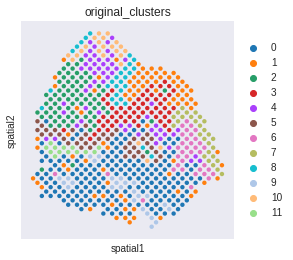

... storing 'original_clusters' as categorical


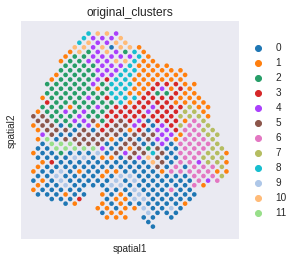

... storing 'original_clusters' as categorical


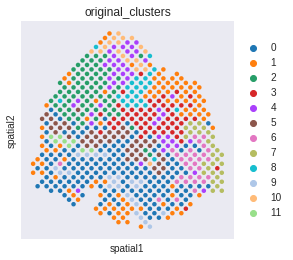

In [9]:
for adata in patient_2:
    sc.pl.spatial(adata, color = 'original_clusters', spot_size=1)

Infer center layer via center alignment.

In [17]:
initial_slice = patient_2[0].copy()
lmbda = len(patient_2)*[1/len(patient_2)]
center_slice, pis = paste.center_align(initial_slice, patient_2, lmbda, random_seed = 5)

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter i

Filtered all slices for common genes. There are 12242 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 12242 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 12242 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 12242 common genes.
Solving Center Mapping NMF Problem:


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


R - R_new: 0.9166369770381337

Iteration: 1
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 12242 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 12242 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 12242 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.011078976191001955

Iteration: 2
Solving Pairwise Slice Alignment Problem:
Filtered all slices for common genes. There are 12242 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 12242 common genes.


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Filtered all slices for common genes. There are 12242 common genes.
Solving Center Mapping NMF Problem:
R - R_new: 0.0009433708436945576



Store NMF decomposition if desired.

In [ ]:
w_path = ''
h_path = ''
center_slice.uns['paste_W'].to_csv(w_path)
center_slice.uns['paste_H'].to_csv(h_path)

Next, we run K-means cluster on the W matrix from NMF on center slice.

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
... storing 'kmeans' as categorical


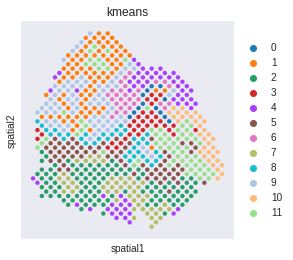

In [18]:
from sklearn.cluster import KMeans

a = center_slice.uns['paste_W'].copy()
# process gene expression
a = (a.T/a.sum(axis=1)).T
a = a + 1
a = np.log(a)

# Number of clusters is chosen to be the same as in the original clusters
kmeans = KMeans(n_clusters=12, random_state=8).fit(a)
l = kmeans.labels_
# inertias.append(kmeans.inertia_) 

# has same spatial coordinates as layer 1
center_slice.obsm['spatial'] = patient_2[0][center_slice.obs_names, :].obsm['spatial']
center_slice.obs['kmeans'] = [str(x) for x in l]
sc.pl.spatial(center_slice, color = 'kmeans', spot_size= 1)

## Calculate Spatial Coherence scores.

In [ ]:
import networkx as nx
from scipy.spatial.distance import cdist

def create_graph(adata, degree = 4):
        """
        Converts spatial coordinates into graph using networkx library.
        
        param: adata - ST Slice 
        param: degree - number of edges per vertex

        return: 1) G - networkx graph
                2) node_dict - dictionary mapping nodes to spots
        """
        D = cdist(adata.obsm['spatial'], adata.obsm['spatial'])
        # Get column indexes of the degree+1 lowest values per row
        idx = np.argsort(D, 1)[:, 0:degree+1]
        # Remove first column since it results in self loops
        idx = idx[:, 1:]

        G = nx.Graph()
        for r in range(len(idx)):
            for c in idx[r]:
                G.add_edge(r, c)

        node_dict = dict(zip(range(adata.shape[0]), adata.obs.index))
        return G, node_dict
    
def generate_graph_from_labels(adata, labels_dict):
    """
    Creates and returns the graph and dictionary {node: cluster_label} for specified layer
    """
    
    g, node_to_spot = create_graph(adata)
    spot_to_cluster = labels_dict

    # remove any nodes that are not mapped to a cluster
    removed_nodes = []
    for node in node_to_spot.keys():
        if (node_to_spot[node] not in spot_to_cluster.keys()):
            removed_nodes.append(node)

    for node in removed_nodes:
        del node_to_spot[node]
        g.remove_node(node)
        
    labels = dict(zip(g.nodes(), [spot_to_cluster[node_to_spot[node]] for node in g.nodes()]))
    return g, labels

def spatial_coherence_score(graph, labels):
    g, l = graph, labels
    true_entropy = spatial_entropy(g, l)
    entropies = []
    for i in range(1000):
        new_l = list(l.values())
        random.shuffle(new_l)
        labels = dict(zip(l.keys(), new_l))
        entropies.append(spatial_entropy(g, labels))
        
    return (true_entropy - np.mean(entropies))/np.std(entropies)

def spatial_entropy(g, labels):
    """
    Calculates spatial entropy of graph  
    """
    # construct contiguity matrix C which counts pairs of cluster edges
    cluster_names = np.unique(list(labels.values()))
    C = pd.DataFrame(0,index=cluster_names, columns=cluster_names)

    for e in g.edges():
        C[labels[e[0]]][labels[e[1]]] += 1

    # calculate entropy from C
    C_sum = C.values.sum()
    H = 0
    for i in range(len(cluster_names)):
        for j in range(i, len(cluster_names)):
            if (i == j):
                z = C[cluster_names[i]][cluster_names[j]]
            else:
                z = C[cluster_names[i]][cluster_names[j]] + C[cluster_names[j]][cluster_names[i]]
            if z != 0:
                H += -(z/C_sum)*math.log(z/C_sum)
    return H

Calculate spatial coherence of original clusters.

In [22]:
scores = []
for adata in patient_2:
    g, l = generate_graph_from_labels(adata, adata.obs['original_clusters'])
    scores.append(spatial_coherence_score(g, l))
print(scores)

# Note that for our plots we take the absolute value.

[-58.45922965156568, -51.88824099644275, -50.29996781628974]


Calculate the spatial coherence score of center slice.

In [24]:
g, l = generate_graph_from_labels(center_slice, center_slice.obs['kmeans'])
s = spatial_coherence_score(g, l)
print(s)

# Note that for our plots we take the absolute value.

-105.42576247316437


Text(0, 0.5, 'Spatial Coherence Score')

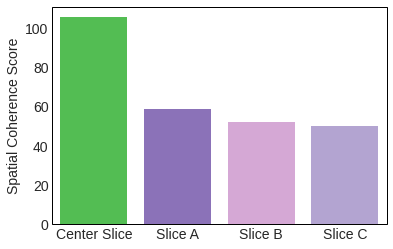

In [21]:
zscores =  s + scores
zscores = np.abs(zscores)

colors = ["#41cf41", "#8766c4", "#dda0dd", "#b19cd9"]
labels = ['Center Slice', 'Slice A', 'Slice B','Slice C']
ax2 = sns.barplot(x = labels, y = zscores, palette= sns.color_palette(colors))
ax2.set_facecolor('white')
ax2.patch.set_edgecolor('black')
ax2.patch.set_linewidth('1')  
ax2.set_ylabel("Spatial Coherence Score", fontsize = 14)

## Getting spatial coherence score from spatial entropy

For a given set of cluster labels, spatial coherence score is calculated by taking the std deviation from the distribution of spatial entropies generated from randomly permuting the cluster labels between spots.

In [27]:
def get_entropy_distribution(adata, cluster_col):
    g, l = generate_graph_from_labels(adata, adata.obs[cluster_col])
    true_entropy = spatial_entropy(g, l)
    entropies = []
    for i in range(1000):
        new_l = list(l.values())
        random.shuffle(new_l)
        labels = dict(zip(l.keys(), new_l))
        entropies.append(spatial_entropy(g, labels))
    return entropies, true_entropy

In [28]:
entropies, true_entropy = get_entropy_distribution(center_slice, 'kmeans')

/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


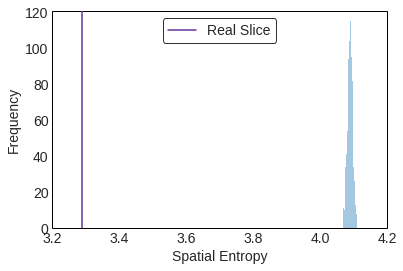

In [33]:
plt.figure(1)
ax = sns.distplot(entropies, bins=20, kde=False)
ax.set(xlim=(3.2, 4.2))
ax.set_xlabel('Spatial Entropy', fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_facecolor('white')
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1')  
plt.axvline(x=true_entropy, label='Real Slice', color = "#663399" )
plt.legend(loc='upper center', fontsize = 14, frameon=True, edgecolor='black', facecolor='white')
plt.tick_params(labelsize=14)

# Accuracy vs Spatial Coherence Plot

For each pair of consecutive slices, we plot the % preserved (pairwise experiment) vs the average spatial coherence score of the two slices (center experiment).

In [26]:
# To avoid clutter, we run the analysis for other patients separately and read in the results
results_path = "../cachedResults/realData/scc_results.csv"
df = pd.read_csv(results_path, index_col= 0)

In [25]:
df

,Patient 2,Patient 2.1,Patient 5,Patient 5.1,Patient 9,Patient 9.1,Patient 10,Patient 10.1
spatial_coherence,-54.588868,-53.019148,-4.797204,-6.580323,-9.961792,-5.872204,-10.023254,-9.959810
percent_preserved,0.716611,0.679683,0.265054,0.357006,0.246324,0.199906,0.542641,0.477571


/home/max/Programs/envs/spatialOT/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

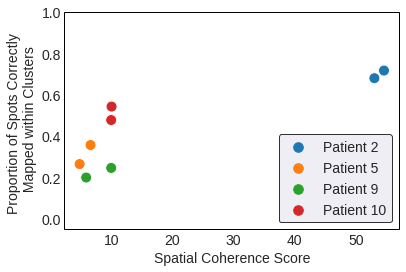

In [28]:
z = df.iloc[0].to_numpy()
p = df.iloc[1].to_numpy()

labels = 2*["Patient 2"] + 2*["Patient 5"] + 2*["Patient 9"] + 2*["Patient 10"]
palette = sns.color_palette(n_colors= 4)

ax = sns.scatterplot(np.abs(z), p, hue = labels, palette=palette, s = 120)
plt.legend(loc='lower right', frameon=True, edgecolor='black', fontsize= 14, markerscale = 1.6)
ax.set_facecolor('white')
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1')  
ax.set_xlabel("Spatial Coherence Score", fontsize = 14)
ax.set_ylabel("Proportion of Spots Correctly \n Mapped within Clusters", fontsize = 14)
ax.set_ylim(-0.05, 1)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)